In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import os

from torch import nn, optim
from torch.optim import lr_scheduler
import time


In [2]:
def sigma68(data): return 0.5*(pd.Series(data).quantile(q = 0.84) - pd.Series(data).quantile(q = 0.16))

In [3]:
from sqlalchemy.engine import create_engine
from sqlalchemy import *
from sqlalchemy.orm import *

engine = create_engine('postgresql://readonly@db03.pau.pic.es/dm')

query = f"""
    SELECT cm.paudm_id, cm.zspec, cm."I_auto", cm.ra, cm.dec, cm.conf, cm."Umag", cm."Bmag", cm."Vmag", cm."Rmag", cm."ICmag", cm."Zmag"
    FROM COSMOS as cm
    """

with engine.begin() as conn:
    conn.execute("SET TRANSACTION ISOLATION LEVEL SERIALIZABLE READ ONLY DEFERRABLE")
    ilbert = pd.read_sql(query, conn)


In [4]:
df_bb = pd.read_csv('/data/astro/scratch/lcabayol/Euclid/referee_report/catalogues/df_bb.csv', header = 0, sep =',')
df_bbnb = pd.read_csv('/data/astro/scratch/lcabayol/Euclid/referee_report/catalogues/df_bbnb.csv', header = 0, sep =',')
df_bbz = pd.read_csv('/data/astro/scratch/lcabayol/Euclid/referee_report/catalogues/df_bbz.csv', header = 0, sep =',')
df_bbnbz = pd.read_csv('/data/astro/scratch/lcabayol/Euclid/referee_report/catalogues/df_bbnbz.csv', header = 0, sep =',')

In [5]:
df_bb = df_bb.rename(columns = {'zb':'zb_bb','rerr':'rerr_bb'})
df_bbnb = df_bbnb.rename(columns = {'zb':'zb_bbnb','rerr':'rerr_bbnb'})
df_bbz = df_bbz.rename(columns = {'zb':'zb_bbz','rerr':'rerr_bbz'})
df_bbnbz = df_bbnbz.rename(columns = {'zb':'zb_bbnbz','rerr':'rerr_bbnbz'})


In [6]:
imag = ilbert[['paudm_id','I_auto','zspec']]
df_bb = df_bb.merge(imag, right_on = 'paudm_id', left_on = 'ref_id')
df = df_bb.merge(df_bbnb[['ref_id','zb_bbnb','rerr_bbnb']], on='ref_id')
df = df.merge(df_bbz[['ref_id','zb_bbz','rerr_bbz']], on='ref_id')
df = df.merge(df_bbnbz[['ref_id','zb_bbnbz','rerr_bbnbz']], on='ref_id')

# PLOTS COSMOS



In [11]:
df_zs = df[df.zspec != 0]

In [12]:
from scipy import stats
dfplot = df_zs.copy()
bin_edges = stats.mstats.mquantiles(dfplot.I_auto, np.arange(0.1,1.01,0.1))
#bin_edges = np.arange(16,25.1,1)

xlab, s68_bb, s68_bbnb, s68_bbz, s68_bbnbz = [],[],[],[], []
outliers_bb, outliers_bbnb, outliers_bbz, outliers_bbnbz = [],[],[],[]
bias_bb, bias_bbnb, bias_bbz, bias_bbnbz  = [],[], [],[]
outliers_bb_cum, outliers_bbnb_cum, outliers_bbz_cum, outliers_bbnbz_cum = [],[],[],[]



for k in range(len(bin_edges)-1):
    edge_min = bin_edges[k]
    edge_max = bin_edges[k+1]
    
    mean_mag =  (edge_max + edge_min) / 2
    
    df_bin = dfplot[(dfplot.I_auto > edge_min) & (dfplot.I_auto < edge_max)]
    df_bin_cum = dfplot[(dfplot.I_auto < edge_max)]

    
    xlab.append(mean_mag)
    s68_bb.append(sigma68(df_bin.rerr_bb))
    s68_bbnb.append(sigma68(df_bin.rerr_bbnb))
    s68_bbz.append(sigma68(df_bin.rerr_bbz))
    s68_bbnbz.append(sigma68(df_bin.rerr_bbnbz))

    
    bias_bb.append(np.nanmedian(df_bin.rerr_bb))
    bias_bbnb.append(np.nanmedian(df_bin.rerr_bbnb))
    bias_bbz.append(np.nanmedian(df_bin.rerr_bbz))
    bias_bbnbz.append(np.nanmedian(df_bin.rerr_bbnbz))

    
    
    outliers_bb.append(len(df_bin[np.abs(df_bin.rerr_bb)>0.15])/len(df_bin))
    outliers_bbnb.append(len(df_bin[np.abs(df_bin.rerr_bbnb)>0.15])/len(df_bin))
    outliers_bbz.append(len(df_bin[np.abs(df_bin.rerr_bbz)>0.15])/len(df_bin))
    outliers_bbnbz.append(len(df_bin[np.abs(df_bin.rerr_bbnbz)>0.15])/len(df_bin))
    
    outliers_bb_cum.append(len(df_bin_cum[np.abs(df_bin_cum.rerr_bb)>0.15])/len(df_bin_cum))
    outliers_bbnb_cum.append(len(df_bin_cum[np.abs(df_bin_cum.rerr_bbnb)>0.15])/len(df_bin_cum))
    outliers_bbz_cum.append(len(df_bin_cum[np.abs(df_bin_cum.rerr_bbz)>0.15])/len(df_bin_cum))
    outliers_bbnbz_cum.append(len(df_bin_cum[np.abs(df_bin_cum.rerr_bbnbz)>0.15])/len(df_bin_cum))



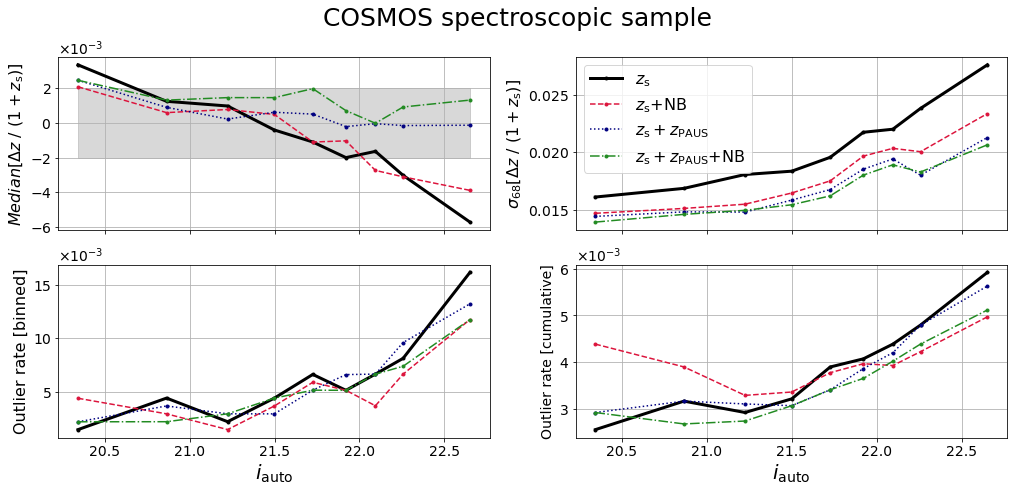

In [14]:
import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
fig,ax = plt.subplots(ncols = 2, nrows = 2, sharex=True, figsize = (17,7))
st = fig.suptitle("COSMOS spectroscopic sample", fontsize=25)


from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax[0,0].yaxis.set_major_formatter(formatter) 
ax[0,1].yaxis.set_major_formatter(formatter) 
ax[1,0].yaxis.set_major_formatter(formatter) 
ax[1,1].yaxis.set_major_formatter(formatter) 


ax[0,0].plot(xlab,bias_bb, ls = '-', marker = '.', color = 'black',lw = 3)
ax[0,0].plot(xlab,bias_bbnb, ls = '--', marker = '.', color = 'crimson')
ax[0,0].plot(xlab,bias_bbz, ls = ':', marker = '.', color = 'navy')
ax[0,0].plot(xlab,bias_bbnbz, ls = '-.', marker = '.', color = 'forestgreen')
ax[0,0].fill_between(xlab,-0.002,0.002, color = 'grey', alpha = 0.3)



ax[0,1].plot(xlab,s68_bb, ls = '-', marker = '.', color = 'black',lw = 3, label = r'$z_{\rm s}$')
ax[0,1].plot(xlab,s68_bbnb, ls = '--', marker = '.', color = 'crimson', label = r'$z_{\rm s}$+NB')
ax[0,1].plot(xlab,s68_bbz, ls = ':', marker = '.', color = 'navy', label = r'$z_{\rm s}+z_{\rm PAUS}$')
ax[0,1].plot(xlab,s68_bbnbz, ls = '-.', marker = '.', color = 'forestgreen', label = r'$z_{\rm s}+z_{\rm PAUS}$+NB')
#ax[0,1].fill_between(xlab,0,0.05, color = 'grey', alpha = 0.3)


ax[1,0].plot(xlab,outliers_bb, ls = '-', marker = '.', color = 'black',lw = 3)
ax[1,0].plot(xlab,outliers_bbnb, ls = '--', marker = '.', color = 'crimson')
ax[1,0].plot(xlab,outliers_bbz, ls = ':', marker = '.', color = 'navy')
ax[1,0].plot(xlab,outliers_bbnbz, ls = '-.', marker = '.', color = 'forestgreen')

ax[1,1].plot(xlab,outliers_bb_cum, ls = '-', marker = '.', color = 'black',lw = 3)
ax[1,1].plot(xlab,outliers_bbnb_cum, ls = '--', marker = '.', color = 'crimson')
ax[1,1].plot(xlab,outliers_bbz_cum, ls = ':', marker = '.', color = 'navy')
ax[1,1].plot(xlab,outliers_bbnbz_cum, ls = '-.', marker = '.', color = 'forestgreen')

ax[0,1].legend(fontsize = 16)

ax[0,0].grid()
ax[1,0].grid()
ax[0,1].grid()
ax[1,1].grid()


ax[0,0].set_ylabel(r'$Median[\Delta z\ /\ (1 + z_{\rm s})]$', fontsize = 16)
ax[0,1].set_ylabel(r'$\sigma_{68}[\Delta z\ /\ (1 + z_{\rm s})]$', fontsize = 16)
ax[1,0].set_ylabel(r'Outlier rate [binned]', fontsize = 16)
ax[1,1].set_ylabel(r'Outlier rate [cumulative]', fontsize = 14)
ax[1,1].set_xlabel(r'$i_{\rm auto}$', fontsize = 20)
ax[1,0].set_xlabel(r'$i_{\rm auto}$', fontsize = 20)



plt.savefig('/data/astro/scratch/lcabayol/Euclid/referee_report/figures/cosmos_imag_zs.pdf', bbox_inches = 'tight')


In [17]:
from scipy import stats
dfplot = df.copy()
bin_edges = stats.mstats.mquantiles(dfplot.zb_true, np.arange(0.1,1.01,0.1))
#bin_edges = np.arange(16,25.1,1)

xlab, s68_bb, s68_bbnb, s68_bbz, s68_bbnbz = [],[],[],[], []
outliers_bb, outliers_bbnb, outliers_bbz, outliers_bbnbz = [],[],[],[]
bias_bb, bias_bbnb, bias_bbz, bias_bbnbz  = [],[], [],[]
outliers_bb_cum, outliers_bbnb_cum, outliers_bbz_cum, outliers_bbnbz_cum = [],[],[],[]



for k in range(len(bin_edges)-1):
    edge_min = bin_edges[k]
    edge_max = bin_edges[k+1]
    
    mean_mag =  (edge_max + edge_min) / 2
    
    df_bin = dfplot[(dfplot.zb_true > edge_min) & (dfplot.zb_true < edge_max)]
    df_bin_cum = dfplot[(dfplot.zb_true < edge_max)]

    
    xlab.append(mean_mag)
    s68_bb.append(sigma68(df_bin.rerr_bb))
    s68_bbnb.append(sigma68(df_bin.rerr_bbnb))
    s68_bbz.append(sigma68(df_bin.rerr_bbz))
    s68_bbnbz.append(sigma68(df_bin.rerr_bbnbz))

    
    bias_bb.append(np.nanmedian(df_bin.rerr_bb))
    bias_bbnb.append(np.nanmedian(df_bin.rerr_bbnb))
    bias_bbz.append(np.nanmedian(df_bin.rerr_bbz))
    bias_bbnbz.append(np.nanmedian(df_bin.rerr_bbnbz))

    
    
    outliers_bb.append(len(df_bin[np.abs(df_bin.rerr_bb)>0.15])/len(df_bin))
    outliers_bbnb.append(len(df_bin[np.abs(df_bin.rerr_bbnb)>0.15])/len(df_bin))
    outliers_bbz.append(len(df_bin[np.abs(df_bin.rerr_bbz)>0.15])/len(df_bin))
    outliers_bbnbz.append(len(df_bin[np.abs(df_bin.rerr_bbnbz)>0.15])/len(df_bin))
    
    outliers_bb_cum.append(len(df_bin_cum[np.abs(df_bin_cum.rerr_bb)>0.15])/len(df_bin_cum))
    outliers_bbnb_cum.append(len(df_bin_cum[np.abs(df_bin_cum.rerr_bbnb)>0.15])/len(df_bin_cum))
    outliers_bbz_cum.append(len(df_bin_cum[np.abs(df_bin_cum.rerr_bbz)>0.15])/len(df_bin_cum))
    outliers_bbnbz_cum.append(len(df_bin_cum[np.abs(df_bin_cum.rerr_bbnbz)>0.15])/len(df_bin_cum))



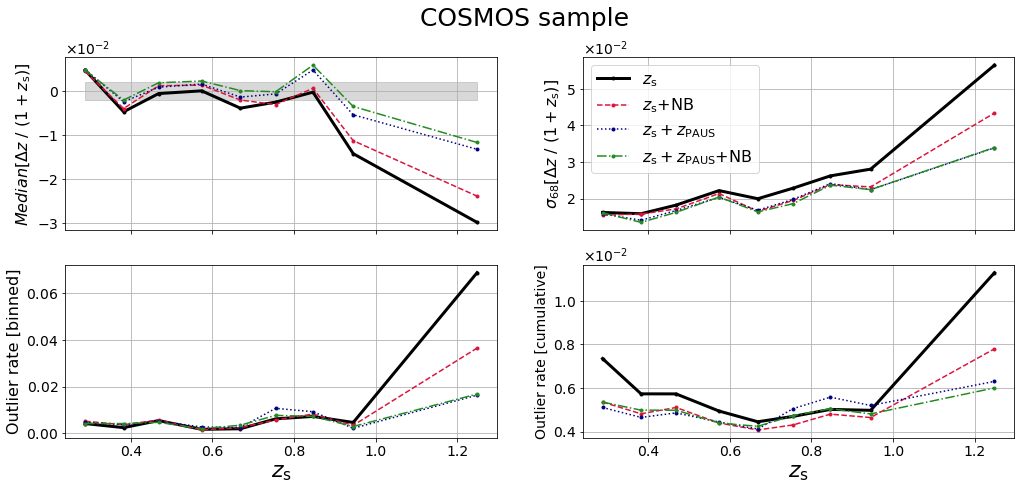

In [18]:
import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
fig,ax = plt.subplots(ncols = 2, nrows = 2, sharex=True, figsize = (17,7))
st = fig.suptitle("COSMOS sample", fontsize=25)


from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax[0,0].yaxis.set_major_formatter(formatter) 
ax[0,1].yaxis.set_major_formatter(formatter) 
ax[1,0].yaxis.set_major_formatter(formatter) 
ax[1,1].yaxis.set_major_formatter(formatter) 


ax[0,0].plot(xlab,bias_bb, ls = '-', marker = '.', color = 'black',lw = 3)
ax[0,0].plot(xlab,bias_bbnb, ls = '--', marker = '.', color = 'crimson')
ax[0,0].plot(xlab,bias_bbz, ls = ':', marker = '.', color = 'navy')
ax[0,0].plot(xlab,bias_bbnbz, ls = '-.', marker = '.', color = 'forestgreen')
ax[0,0].fill_between(xlab,-0.002,0.002, color = 'grey', alpha = 0.3)



ax[0,1].plot(xlab,s68_bb, ls = '-', marker = '.', color = 'black',lw = 3, label = r'$z_{\rm s}$')
ax[0,1].plot(xlab,s68_bbnb, ls = '--', marker = '.', color = 'crimson', label = r'$z_{\rm s}$+NB')
ax[0,1].plot(xlab,s68_bbz, ls = ':', marker = '.', color = 'navy', label = r'$z_{\rm s}+z_{\rm PAUS}$')
ax[0,1].plot(xlab,s68_bbnbz, ls = '-.', marker = '.', color = 'forestgreen', label = r'$z_{\rm s}+z_{\rm PAUS}$+NB')
#ax[0,1].fill_between(xlab,0,0.05, color = 'grey', alpha = 0.3)


ax[1,0].plot(xlab,outliers_bb, ls = '-', marker = '.', color = 'black',lw = 3)
ax[1,0].plot(xlab,outliers_bbnb, ls = '--', marker = '.', color = 'crimson')
ax[1,0].plot(xlab,outliers_bbz, ls = ':', marker = '.', color = 'navy')
ax[1,0].plot(xlab,outliers_bbnbz, ls = '-.', marker = '.', color = 'forestgreen')

ax[1,1].plot(xlab,outliers_bb_cum, ls = '-', marker = '.', color = 'black',lw = 3)
ax[1,1].plot(xlab,outliers_bbnb_cum, ls = '--', marker = '.', color = 'crimson')
ax[1,1].plot(xlab,outliers_bbz_cum, ls = ':', marker = '.', color = 'navy')
ax[1,1].plot(xlab,outliers_bbnbz_cum, ls = '-.', marker = '.', color = 'forestgreen')

ax[0,1].legend(fontsize = 16)

ax[0,0].grid()
ax[1,0].grid()
ax[0,1].grid()
ax[1,1].grid()


ax[0,0].set_ylabel(r'$Median[\Delta z\ /\ (1 + z_{\rm s})]$', fontsize = 16)
ax[0,1].set_ylabel(r'$\sigma_{68}[\Delta z\ /\ (1 + z_{\rm s})]$', fontsize = 16)
ax[1,0].set_ylabel(r'Outlier rate [binned]', fontsize = 16)
ax[1,1].set_ylabel(r'Outlier rate [cumulative]', fontsize = 14)
#ax[1,1].set_xlabel(r'$z_{\rm PAUS+Cosmos}$', fontsize = 22)
#ax[1,0].set_xlabel(r'$z_{\rm PAUS+Cosmos}$', fontsize = 22)
ax[1,1].set_xlabel(r'$z_{\rm s}$', fontsize = 22)
ax[1,0].set_xlabel(r'$z_{\rm s}$', fontsize = 22)

plt.savefig('/data/astro/scratch/lcabayol/Euclid/referee_report/figures/cosmos_zs.pdf', bbox_inches = 'tight')


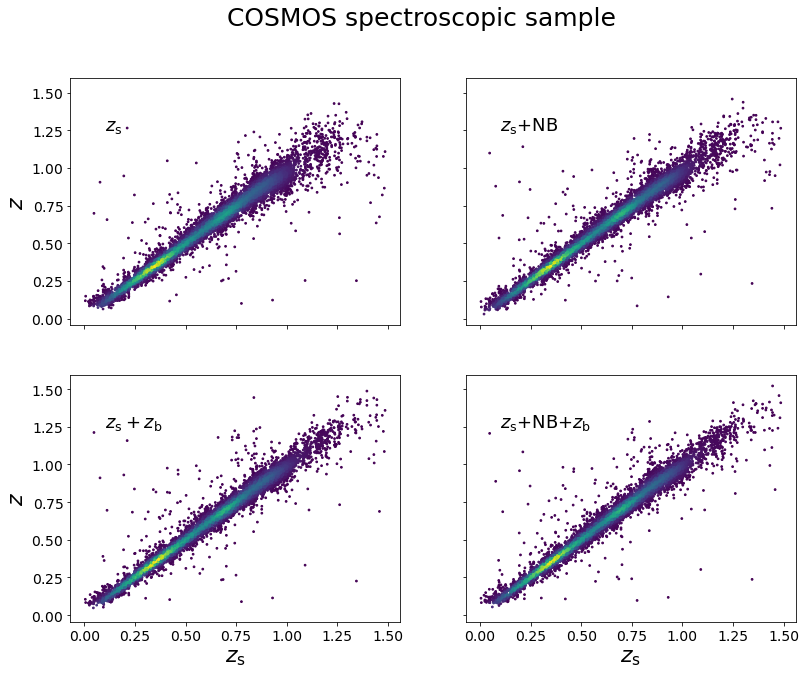

In [40]:
import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
fig,ax = plt.subplots(ncols = 2, nrows = 2, sharex=True, sharey = True, figsize = (13,10))
st = fig.suptitle("COSMOS spectroscopic sample", fontsize=25)


from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax[0,0].yaxis.set_major_formatter(formatter) 
ax[0,1].yaxis.set_major_formatter(formatter) 
ax[1,0].yaxis.set_major_formatter(formatter) 
ax[1,1].yaxis.set_major_formatter(formatter) 

"""xy = np.vstack([df_zs.zb_true, df_zs.zb_bb])
z_bb = gaussian_kde(xy)(xy)

xy = np.vstack([df_zs.zb_true, df_zs.zb_bbnb])
z_bbnb = gaussian_kde(xy)(xy)

xy = np.vstack([df_zs.zb_true, df_zs.zb_bbz])
z_bbz = gaussian_kde(xy)(xy)

xy = np.vstack([df_zs.zb_true, df_zs.zb_bbnbz])
z_bbnbz = gaussian_kde(xy)(xy)"""


ax[0,0].scatter(df_zs.zb_true, df_zs.zb_bb, c = z_bb, s = 3)
ax[0,1].scatter(df_zs.zb_true, df_zs.zb_bbnb, c = z_bbnb, s = 3)
ax[1,0].scatter(df_zs.zb_true, df_zs.zb_bbz, c = z_bbz, s = 3)
ax[1,1].scatter(df_zs.zb_true, df_zs.zb_bbnbz, c = z_bbnbz, s = 3)

ax[0,0].text(x = 0.1, y = 1.25, s = r'$z_{\rm s}$', fontsize = 18)
ax[0,1].text(x = 0.1, y = 1.25, s = r'$z_{\rm s}$+NB', fontsize = 18)
ax[1,0].text(x = 0.1, y = 1.25, s = r'$z_{\rm s}+z_{\rm b}$', fontsize = 18)
ax[1,1].text(x = 0.1, y = 1.25, s = r'$z_{\rm s}$+NB+$z_{\rm b}$', fontsize = 18)


ax[0,0].set_ylabel(r'$z$', fontsize = 22)
ax[1,0].set_ylabel(r'$z$', fontsize = 22)
ax[1,1].set_xlabel(r'$z_{\rm s}$', fontsize = 22)
ax[1,0].set_xlabel(r'$z_{\rm s}$', fontsize = 22)

plt.savefig('/data/astro/scratch/lcabayol/Euclid/referee_report/figures/scatter_cosmos_zs.pdf', bbox_inches = 'tight')


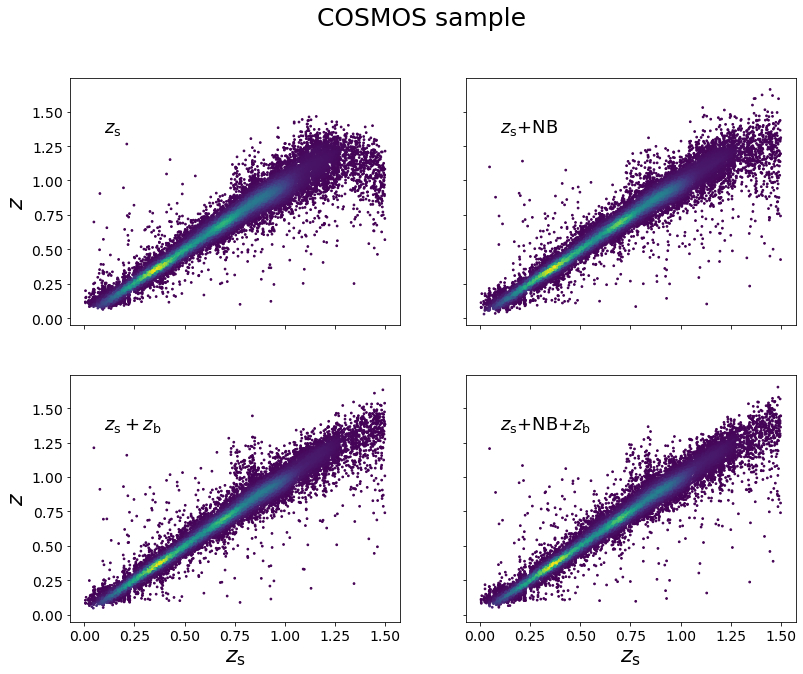

In [44]:
import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
fig,ax = plt.subplots(ncols = 2, nrows = 2, sharex=True, sharey = True, figsize = (13,10))
st = fig.suptitle("COSMOS sample", fontsize=25)


from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax[0,0].yaxis.set_major_formatter(formatter) 
ax[0,1].yaxis.set_major_formatter(formatter) 
ax[1,0].yaxis.set_major_formatter(formatter) 
ax[1,1].yaxis.set_major_formatter(formatter) 

#xy = np.vstack([df.zb_true, df.zb_bb])
#z_bb = gaussian_kde(xy)(xy)

#xy = np.vstack([df.zb_true, df.zb_bbnb])
#z_bbnb = gaussian_kde(xy)(xy)

#xy = np.vstack([df.zb_true, df.zb_bbz])
#z_bbz = gaussian_kde(xy)(xy)

#xy = np.vstack([df.zb_true, df.zb_bbnbz])
#z_bbnbz = gaussian_kde(xy)(xy)


ax[0,0].scatter(df.zb_true, df.zb_bb, c = z_bb, s = 3)
ax[0,1].scatter(df.zb_true, df.zb_bbnb, c = z_bbnb, s = 3)
ax[1,0].scatter(df.zb_true, df.zb_bbz, c = z_bbz, s = 3)
ax[1,1].scatter(df.zb_true, df.zb_bbnbz, c = z_bbnbz, s = 3)

ax[0,0].text(x = 0.1, y = 1.35, s = r'$z_{\rm s}$', fontsize = 18)
ax[0,1].text(x = 0.1, y = 1.35, s = r'$z_{\rm s}$+NB', fontsize = 18)
ax[1,0].text(x = 0.1, y = 1.35, s = r'$z_{\rm s}+z_{\rm b}$', fontsize = 18)
ax[1,1].text(x = 0.1, y = 1.35, s = r'$z_{\rm s}$+NB+$z_{\rm b}$', fontsize = 18)


ax[0,0].set_ylabel(r'$z$', fontsize = 22)
ax[1,0].set_ylabel(r'$z$', fontsize = 22)
ax[1,1].set_xlabel(r'$z_{\rm s}$', fontsize = 22)
ax[1,0].set_xlabel(r'$z_{\rm s}$', fontsize = 22)

plt.savefig('/data/astro/scratch/lcabayol/Euclid/referee_report/figures/scatter_cosmos.pdf', bbox_inches = 'tight')


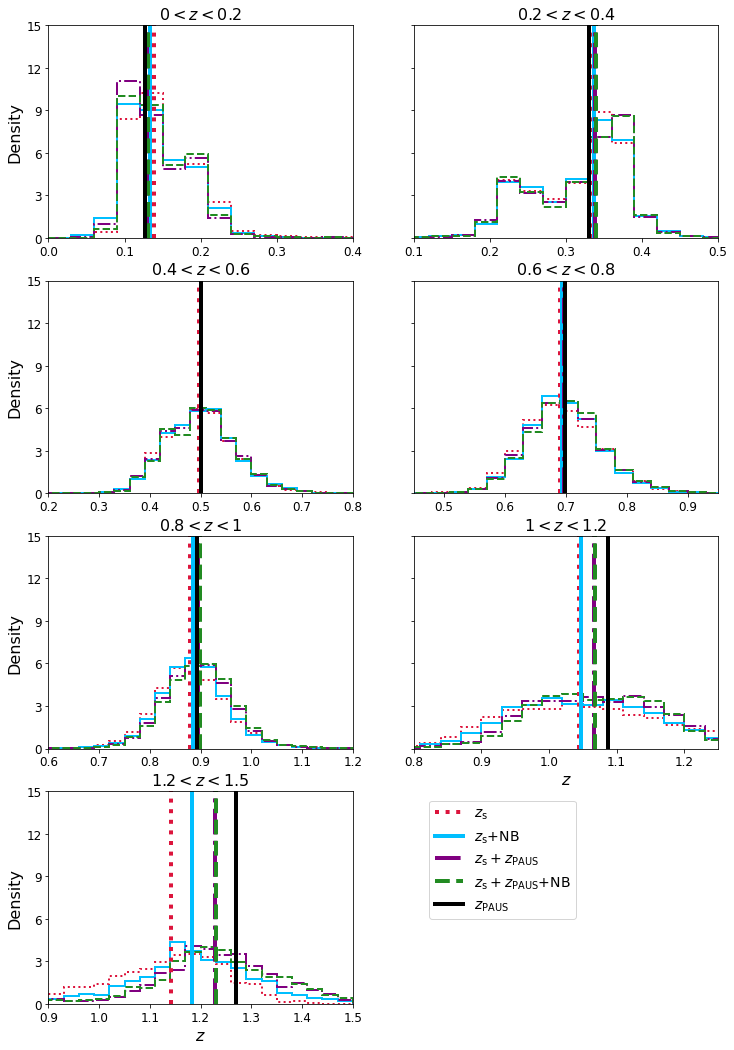

In [21]:
from matplotlib.ticker import FormatStrFormatter
colors = ['navy', 'darkorange','darkgreen','crimson','deepskyblue']


tomographic_bins = [0,0.2,0.4,0.6,0.8,1,1.2,1.5]
kwargs = dict(bins = 50, range = (0,1.5), density = True,  lw = 2)


pausmedian, bbmedian,nbmedian,bbpzmedian,bbnbpzmedian = [],[],[],[],[]

fig, ax = plt.subplots(nrows = 4, ncols = 2, figsize = (12,18), sharey = True)

#bin 1 (0,0.2):

tbin = df[(df.zb_true> tomographic_bins[0])&(df.zb_true < tomographic_bins[1])]

pausmedian.append(tbin.zb_true.median())
bbmedian.append(tbin.zb_bb.median())
nbmedian.append(tbin.zb_bbnb.median())
bbpzmedian.append(tbin.zb_bbz.median())
bbnbpzmedian.append(tbin.zb_bbnbz.median())




ax[0,0].hist(tbin.zb_bb,**kwargs, ls = ':', color = 'crimson', histtype = 'step', label = '')
ax[0,0].hist(tbin.zb_bbnb,**kwargs, ls = '-', color = 'deepskyblue', histtype = 'step', label = '')
ax[0,0].hist(tbin.zb_bbz,**kwargs, ls = '-.', color = 'purple', histtype = 'step', label = '')
ax[0,0].hist(tbin.zb_bbnbz,**kwargs, ls = '--', color = 'forestgreen', histtype = 'step', label = '')


ax[0,0].axvline(np.median(tbin.zb_bb), ls = ':', color = 'crimson', label = '', lw = 4)
ax[0,0].axvline(np.median(tbin.zb_bbnb), ls = '-', color = 'deepskyblue', label = '',lw = 4)
ax[0,0].axvline(np.median(tbin.zb_bbz), ls = '-.', color = 'purple', label = '', lw = 4)
ax[0,0].axvline(np.median(tbin.zb_bbnbz), ls = '--', color = 'forestgreen', label = '',lw = 4)

ax[0,0].axvline(np.median(tbin.zb_true), ls = '-', color = 'black', label = '',lw = 4)
    

xticks = np.round(np.arange(0,1.6,0.1),1)
ax[0,0].set_xticks(xticks)
ax[0,0].set_xlim(0,0.4)
ax[0,0].set_xticklabels(xticks,fontsize =12)




#bin 2 (0.2,0.4):

tbin = df[(df.zb_true> tomographic_bins[1])&(df.zb_true < tomographic_bins[2])]


pausmedian.append(tbin.zb_true.median())
bbmedian.append(tbin.zb_bb.median())
nbmedian.append(tbin.zb_bbnb.median())
bbpzmedian.append(tbin.zb_bbz.median())
bbnbpzmedian.append(tbin.zb_bbnbz.median())




ax[0,1].hist(tbin.zb_bb,**kwargs, ls = ':', color = 'crimson', histtype = 'step', label = '')
ax[0,1].hist(tbin.zb_bbnb,**kwargs, ls = '-', color = 'deepskyblue', histtype = 'step', label = '')
ax[0,1].hist(tbin.zb_bbz,**kwargs, ls = '-.', color = 'purple', histtype = 'step', label = '')
ax[0,1].hist(tbin.zb_bbnbz,**kwargs, ls = '--', color = 'forestgreen', histtype = 'step', label = '')


ax[0,1].axvline(np.median(tbin.zb_bb), ls = ':', color = 'crimson', label = '', lw = 4)
ax[0,1].axvline(np.median(tbin.zb_bbnb), ls = '-', color = 'deepskyblue', label = '',lw = 4)
ax[0,1].axvline(np.median(tbin.zb_bbz), ls = '-.', color = 'purple', label = '', lw = 4)
ax[0,1].axvline(np.median(tbin.zb_bbnbz), ls = '--', color = 'forestgreen', label = '',lw = 4)

ax[0,1].axvline(np.median(tbin.zb_true), ls = '-', color = 'black', label = '',lw = 4)
    
ax[0,1].set_xticks(xticks)
ax[0,1].set_xlim(0.1,0.5)
ax[0,1].set_xticklabels(xticks,fontsize =12)



#bin 3 (0.4,0.6):

tbin = df[(df.zb_true> tomographic_bins[2])&(df.zb_true < tomographic_bins[3])]


pausmedian.append(tbin.zb_true.median())
bbmedian.append(tbin.zb_bb.median())
nbmedian.append(tbin.zb_bbnb.median())
bbpzmedian.append(tbin.zb_bbz.median())
bbnbpzmedian.append(tbin.zb_bbnbz.median())




ax[1,0].hist(tbin.zb_bb,**kwargs, ls = ':', color = 'crimson', histtype = 'step', label = '')
ax[1,0].hist(tbin.zb_bbnb,**kwargs, ls = '-', color = 'deepskyblue', histtype = 'step', label = '')
ax[1,0].hist(tbin.zb_bbz,**kwargs, ls = '-.', color = 'purple', histtype = 'step', label = '')
ax[1,0].hist(tbin.zb_bbnbz,**kwargs, ls = '--', color = 'forestgreen', histtype = 'step', label = '')


ax[1,0].axvline(np.median(tbin.zb_bb), ls = ':', color = 'crimson', label = '', lw = 4)
ax[1,0].axvline(np.median(tbin.zb_bbnb), ls = '-', color = 'deepskyblue', label = '',lw = 4)
ax[1,0].axvline(np.median(tbin.zb_bbz), ls = '-.', color = 'purple', label = '', lw = 4)
ax[1,0].axvline(np.median(tbin.zb_bbnbz), ls = '--', color = 'forestgreen', label = '',lw = 4)

ax[1,0].axvline(np.median(tbin.zb_true), ls = '-', color = 'black', label = '',lw = 4)
    

    
ax[1,0].set_xticks(xticks)
ax[1,0].set_xlim(0.2,0.8)
ax[1,0].set_xticklabels(xticks,fontsize =12)




#bin 4 (0.6,0.8):

tbin = df[(df.zb_true> tomographic_bins[3])&(df.zb_true < tomographic_bins[4])]


pausmedian.append(tbin.zb_true.median())
bbmedian.append(tbin.zb_bb.median())
nbmedian.append(tbin.zb_bbnb.median())
bbpzmedian.append(tbin.zb_bbz.median())
bbnbpzmedian.append(tbin.zb_bbnbz.median())



ax[1,1].hist(tbin.zb_bb,**kwargs, ls = ':', color = 'crimson', histtype = 'step', label = '')
ax[1,1].hist(tbin.zb_bbnb,**kwargs, ls = '-', color = 'deepskyblue', histtype = 'step', label = '')
ax[1,1].hist(tbin.zb_bbz,**kwargs, ls = '-.', color = 'purple', histtype = 'step', label = '')
ax[1,1].hist(tbin.zb_bbnbz,**kwargs, ls = '--', color = 'forestgreen', histtype = 'step', label = '')


ax[1,1].axvline(np.median(tbin.zb_bb), ls = ':', color = 'crimson', label = '', lw = 4)
ax[1,1].axvline(np.median(tbin.zb_bbnb), ls = '-', color = 'deepskyblue', label = '',lw = 4)
ax[1,1].axvline(np.median(tbin.zb_bbz), ls = '-.', color = 'purple', label = '', lw = 4)
ax[1,1].axvline(np.median(tbin.zb_bbnbz), ls = '--', color = 'forestgreen', label = '',lw = 4)

ax[1,1].axvline(np.median(tbin.zb_true), ls = '-', color = 'black', label = '',lw = 4)
    

    
ax[1,1].set_xticks(xticks)
ax[1,1].set_xlim(0.45,0.95)
ax[1,1].set_xticklabels(xticks,fontsize =12)


#bin 4 (0.8,1):

tbin = df[(df.zb_true> tomographic_bins[4])&(df.zb_true < tomographic_bins[5])]


pausmedian.append(tbin.zb_true.median())
bbmedian.append(tbin.zb_bb.median())
nbmedian.append(tbin.zb_bbnb.median())
bbpzmedian.append(tbin.zb_bbz.median())
bbnbpzmedian.append(tbin.zb_bbnbz.median())



ax[2,0].hist(tbin.zb_bb,**kwargs, ls = ':', color = 'crimson', histtype = 'step', label = '')
ax[2,0].hist(tbin.zb_bbnb,**kwargs, ls = '-', color = 'deepskyblue', histtype = 'step', label = '')
ax[2,0].hist(tbin.zb_bbz,**kwargs, ls = '-.', color = 'purple', histtype = 'step', label = '')
ax[2,0].hist(tbin.zb_bbnbz,**kwargs, ls = '--', color = 'forestgreen', histtype = 'step', label = '')


ax[2,0].axvline(np.median(tbin.zb_bb), ls = ':', color = 'crimson', label = '', lw = 4)
ax[2,0].axvline(np.median(tbin.zb_bbnb), ls = '-', color = 'deepskyblue', label = '',lw = 4)
ax[2,0].axvline(np.median(tbin.zb_bbz), ls = '-.', color = 'purple', label = '', lw = 4)
ax[2,0].axvline(np.median(tbin.zb_bbnbz), ls = '--', color = 'forestgreen', label = '',lw = 4)

ax[2,0].axvline(np.median(tbin.zb_true), ls = '-', color = 'black', label = '',lw = 4)
    


    
ax[2,0].set_xticks(xticks)
ax[2,0].set_xticklabels(xticks,fontsize =12)
ax[2,0].set_xlim(0.6,1.2)


#bin 4 (1,1.2):

tbin = df[(df.zb_true> tomographic_bins[5])&(df.zb_true < tomographic_bins[6])]


pausmedian.append(tbin.zb_true.median())
bbmedian.append(tbin.zb_bb.median())
nbmedian.append(tbin.zb_bbnb.median())
bbpzmedian.append(tbin.zb_bbz.median())
bbnbpzmedian.append(tbin.zb_bbnbz.median())




ax[2,1].hist(tbin.zb_bb,**kwargs, ls = ':', color = 'crimson', histtype = 'step', label = '')
ax[2,1].hist(tbin.zb_bbnb,**kwargs, ls = '-', color = 'deepskyblue', histtype = 'step', label = '')
ax[2,1].hist(tbin.zb_bbz,**kwargs, ls = '-.', color = 'purple', histtype = 'step', label = '')
ax[2,1].hist(tbin.zb_bbnbz,**kwargs, ls = '--', color = 'forestgreen', histtype = 'step', label = '')


ax[2,1].axvline(np.median(tbin.zb_bb), ls = ':', color = 'crimson', label = '', lw = 4)
ax[2,1].axvline(np.median(tbin.zb_bbnb), ls = '-', color = 'deepskyblue', label = '',lw = 4)
ax[2,1].axvline(np.median(tbin.zb_bbz), ls = '-.', color = 'purple', label = '', lw = 4)
ax[2,1].axvline(np.median(tbin.zb_bbnbz), ls = '--', color = 'forestgreen', label = '',lw = 4)

ax[2,1].axvline(np.median(tbin.zb_true), ls = '-', color = 'black', label = '',lw = 4)
    

    
ax[2,1].set_xticks(xticks)
ax[2,1].set_xticklabels(xticks,fontsize =12)
ax[2,1].set_xlim(0.8,1.25)



#bin 4 (1.2,1.4):

tbin = df[(df.zb_true> tomographic_bins[6])&(df.zb_true < tomographic_bins[7])]


pausmedian.append(tbin.zb_true.median())
bbmedian.append(tbin.zb_bb.median())
nbmedian.append(tbin.zb_bbnb.median())
bbpzmedian.append(tbin.zb_bbz.median())
bbnbpzmedian.append(tbin.zb_bbnbz.median())



ax[3,0].hist(tbin.zb_bb,**kwargs, ls = ':', color = 'crimson', histtype = 'step', label = '')
ax[3,0].hist(tbin.zb_bbnb,**kwargs, ls = '-', color = 'deepskyblue', histtype = 'step', label = '')
ax[3,0].hist(tbin.zb_bbz,**kwargs, ls = '-.', color = 'purple', histtype = 'step', label = '')
ax[3,0].hist(tbin.zb_bbnbz,**kwargs, ls = '--', color = 'forestgreen', histtype = 'step', label = '')

ax[3,0].axvline(np.median(tbin.zb_bb), ls = ':', color = 'crimson', lw = 4,label = r'$z_{\rm s}$')
ax[3,0].axvline(np.median(tbin.zb_bbnb), ls = '-', color = 'deepskyblue',lw = 4,label = r'$z_{\rm s}$+NB')
ax[3,0].axvline(np.median(tbin.zb_bbz), ls = '-.', color = 'purple', lw = 4,label = r'$z_{\rm s}+z_{\rm PAUS} $')
ax[3,0].axvline(np.median(tbin.zb_bbnbz), ls = '--', color = 'forestgreen',lw = 4,label = r'$z_{\rm s}+z_{\rm PAUS}$+NB')


ax[3,0].axvline(np.median(tbin.zb_true), ls = '-', color = 'black', label = r'$z_{\rm PAUS}$',lw = 4)
    
ax[3,0].set_xticks(xticks)
ax[3,0].set_xticklabels(xticks,fontsize =12)
ax[3,0].set_xlim(0.9,1.5)

ax[3,1].set_visible(False)


#-------------------------------------------------------------------


ax[2,1].set_xlabel(r'$z$',fontsize = 16)
ax[3,0].set_xlabel(r'$z$',fontsize = 16)
ax[0,0].set_ylabel('Density',fontsize = 16)
ax[1,0].set_ylabel('Density',fontsize = 16)
ax[2,0].set_ylabel('Density',fontsize = 16)
ax[3,0].set_ylabel('Density',fontsize = 16)


ax[0,1].set_yticklabels([],fontsize =14)
ax[1,1].set_yticklabels([],fontsize =14)


yticks = np.arange(0,18,3)

ax[0,1].set_yticklabels([],fontsize =14)
ax[1,1].set_yticklabels([],fontsize =14)

ax[0,0].set_yticks(yticks)
ax[0,0].set_yticklabels(yticks,fontsize =12)

ax[1,0].set_yticklabels(yticks,fontsize =12)
ax[2,0].set_yticklabels(yticks,fontsize =12)
ax[3,0].set_yticklabels(yticks,fontsize =12)


ax[0,0].set_title(r'$0 < z < 0.2$', fontsize = 16)
ax[0,1].set_title(r'$0.2 < z < 0.4$', fontsize = 16)
ax[1,0].set_title(r'$0.4 < z < 0.6$', fontsize = 16)
ax[1,1].set_title(r'$0.6 < z < 0.8$', fontsize = 16)
ax[2,0].set_title(r'$0.8 < z < 1$', fontsize = 16)
ax[2,1].set_title(r'$1 < z < 1.2$', fontsize = 16)
ax[3,0].set_title(r'$1.2 < z < 1.5$', fontsize = 16)


ax[3,0].legend(fontsize = 14, loc = [1.25,0.4])

plt.savefig('/data/astro/scratch/lcabayol/Euclid/referee_report/figures/Nzs_cosmos.pdf', bbox_inches = 'tight')


## PLOTS FLAGSHIP

In [100]:
df_bb = pd.read_csv('/data/astro/scratch/lcabayol/Euclid/referee_report/catalogues/df_bb_flagship.csv', header = 0, sep =',')
df_bbnb = pd.read_csv('/data/astro/scratch/lcabayol/Euclid/referee_report/catalogues/df_bbnb_flagship.csv', header = 0, sep =',')
df_bbz = pd.read_csv('/data/astro/scratch/lcabayol/Euclid/referee_report/catalogues/df_bbz_flagship.csv', header = 0, sep =',')
df_bbnbz = pd.read_csv('/data/astro/scratch/lcabayol/Euclid/referee_report/catalogues/df_bbnbz_flagship.csv', header = 0, sep =',')

In [101]:
df = df_bb.join(df_bbnb[['zb_bbnb','rerr_bbnb']])
df = df.join(df_bbz[['zb_bbz','rerr_bbz']])
df = df.join(df_bbnbz[['zb_bbnbz','rerr_bbnbz']])

In [102]:
from scipy import stats

bin_edges = stats.mstats.mquantiles(df.imag, np.arange(0.1,1.01,0.1))
#bin_edges = np.arange(18,25.1,1)

xlab, s68_bb, s68_bbnb, s68_bbz, s68_bbnbz = [],[],[],[], []
outliers_bb, outliers_bbnb, outliers_bbz, outliers_bbnbz = [],[],[],[]
bias_bb, bias_bbnb, bias_bbz, bias_bbnbz  = [],[], [],[]
outliers_bb_cum, outliers_bbnb_cum, outliers_bbz_cum, outliers_bbnbz_cum = [],[],[],[]



for k in range(len(bin_edges)-1):
    edge_min = bin_edges[k]
    edge_max = bin_edges[k+1]
    
    mean_mag =  (edge_max + edge_min) / 2
    
    df_bin = df[(df.imag > edge_min) & (df.imag < edge_max)]
    df_bin_cum = df[(df.imag < edge_max)]

    
    xlab.append(mean_mag)
    s68_bb.append(sigma68(df_bin.rerr_bb))
    s68_bbnb.append(sigma68(df_bin.rerr_bbnb))
    s68_bbz.append(sigma68(df_bin.rerr_bbz))
    s68_bbnbz.append(sigma68(df_bin.rerr_bbnbz))

    
    bias_bb.append(np.nanmedian(df_bin.rerr_bb))
    bias_bbnb.append(np.nanmedian(df_bin.rerr_bbnb))
    bias_bbz.append(np.nanmedian(df_bin.rerr_bbz))
    bias_bbnbz.append(np.nanmedian(df_bin.rerr_bbnbz))

    
    
    outliers_bb.append(len(df_bin[np.abs(df_bin.rerr_bb)>0.15])/len(df_bin))
    outliers_bbnb.append(len(df_bin[np.abs(df_bin.rerr_bbnb)>0.15])/len(df_bin))
    outliers_bbz.append(len(df_bin[np.abs(df_bin.rerr_bbz)>0.15])/len(df_bin))
    outliers_bbnbz.append(len(df_bin[np.abs(df_bin.rerr_bbnbz)>0.15])/len(df_bin))
    
    outliers_bb_cum.append(len(df_bin_cum[np.abs(df_bin_cum.rerr_bb)>0.15])/len(df))
    outliers_bbnb_cum.append(len(df_bin_cum[np.abs(df_bin_cum.rerr_bbnb)>0.15])/len(df))
    outliers_bbz_cum.append(len(df_bin_cum[np.abs(df_bin_cum.rerr_bbz)>0.15])/len(df))
    outliers_bbnbz_cum.append(len(df_bin_cum[np.abs(df_bin_cum.rerr_bbnbz)>0.15])/len(df))



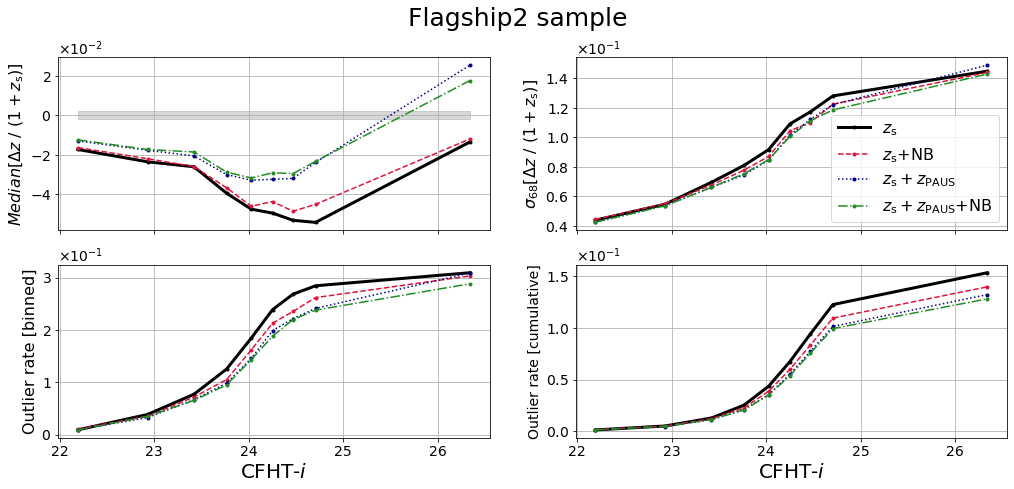

In [103]:
import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
fig,ax = plt.subplots(ncols = 2, nrows = 2, sharex=True, figsize = (17,7))
st = fig.suptitle("Flagship2 sample", fontsize=25)


from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax[0,0].yaxis.set_major_formatter(formatter) 
ax[0,1].yaxis.set_major_formatter(formatter) 
ax[1,0].yaxis.set_major_formatter(formatter) 
ax[1,1].yaxis.set_major_formatter(formatter) 


ax[0,0].plot(xlab,bias_bb, ls = '-', marker = '.', color = 'black',lw = 3)
ax[0,0].plot(xlab,bias_bbnb, ls = '--', marker = '.', color = 'crimson')
ax[0,0].plot(xlab,bias_bbz, ls = ':', marker = '.', color = 'navy')
ax[0,0].plot(xlab,bias_bbnbz, ls = '-.', marker = '.', color = 'forestgreen')
ax[0,0].fill_between(xlab,-0.002,0.002, color = 'grey', alpha = 0.3)



ax[0,1].plot(xlab,s68_bb, ls = '-', marker = '.', color = 'black',lw = 3, label = r'$z_{\rm s}$')
ax[0,1].plot(xlab,s68_bbnb, ls = '--', marker = '.', color = 'crimson', label = r'$z_{\rm s}$+NB')
ax[0,1].plot(xlab,s68_bbz, ls = ':', marker = '.', color = 'navy', label = r'$z_{\rm s}+z_{\rm PAUS}$')
ax[0,1].plot(xlab,s68_bbnbz, ls = '-.', marker = '.', color = 'forestgreen', label = r'$z_{\rm s}+z_{\rm PAUS}$+NB')
#ax[0,1].fill_between(xlab,0,0.05, color = 'grey', alpha = 0.3)


ax[1,0].plot(xlab,outliers_bb, ls = '-', marker = '.', color = 'black',lw = 3)
ax[1,0].plot(xlab,outliers_bbnb, ls = '--', marker = '.', color = 'crimson')
ax[1,0].plot(xlab,outliers_bbz, ls = ':', marker = '.', color = 'navy')
ax[1,0].plot(xlab,outliers_bbnbz, ls = '-.', marker = '.', color = 'forestgreen')

ax[1,1].plot(xlab,outliers_bb_cum, ls = '-', marker = '.', color = 'black',lw = 3)
ax[1,1].plot(xlab,outliers_bbnb_cum, ls = '--', marker = '.', color = 'crimson')
ax[1,1].plot(xlab,outliers_bbz_cum, ls = ':', marker = '.', color = 'navy')
ax[1,1].plot(xlab,outliers_bbnbz_cum, ls = '-.', marker = '.', color = 'forestgreen')

ax[0,1].legend(fontsize = 16)

ax[0,0].grid()
ax[1,0].grid()
ax[0,1].grid()
ax[1,1].grid()


ax[0,0].set_ylabel(r'$Median[\Delta z\ /\ (1 + z_{\rm s})]$', fontsize = 16)
ax[0,1].set_ylabel(r'$\sigma_{68}[\Delta z\ /\ (1 + z_{\rm s})]$', fontsize = 16)
ax[1,0].set_ylabel(r'Outlier rate [binned]', fontsize = 16)
ax[1,1].set_ylabel(r'Outlier rate [cumulative]', fontsize = 14)
ax[1,1].set_xlabel(r'CFHT-$i$', fontsize = 20)
ax[1,0].set_xlabel(r'CFHT-$i$', fontsize = 20)



plt.savefig('/data/astro/scratch/lcabayol/Euclid/referee_report/figures/flagship_imag.pdf', bbox_inches = 'tight')


In [106]:
from scipy import stats
dfplot = df.copy()
#bin_edges = stats.mstats.mquantiles(dfplot.zb_true, np.arange(0.1,1.01,0.1))
bin_edges = np.arange(0,1.51,.1)

xlab, s68_bb, s68_bbnb, s68_bbz, s68_bbnbz = [],[],[],[], []
outliers_bb, outliers_bbnb, outliers_bbz, outliers_bbnbz = [],[],[],[]
bias_bb, bias_bbnb, bias_bbz, bias_bbnbz  = [],[], [],[]
outliers_bb_cum, outliers_bbnb_cum, outliers_bbz_cum, outliers_bbnbz_cum = [],[],[],[]



for k in range(len(bin_edges)-1):
    edge_min = bin_edges[k]
    edge_max = bin_edges[k+1]
    
    mean_mag =  (edge_max + edge_min) / 2
    
    df_bin = dfplot[(dfplot.zb_true > edge_min) & (dfplot.zb_true < edge_max)]
    df_bin_cum = dfplot[(dfplot.zb_true < edge_max)]

    
    xlab.append(mean_mag)
    s68_bb.append(sigma68(df_bin.rerr_bb))
    s68_bbnb.append(sigma68(df_bin.rerr_bbnb))
    s68_bbz.append(sigma68(df_bin.rerr_bbz))
    s68_bbnbz.append(sigma68(df_bin.rerr_bbnbz))

    
    bias_bb.append(np.nanmedian(df_bin.rerr_bb))
    bias_bbnb.append(np.nanmedian(df_bin.rerr_bbnb))
    bias_bbz.append(np.nanmedian(df_bin.rerr_bbz))
    bias_bbnbz.append(np.nanmedian(df_bin.rerr_bbnbz))

    
    
    outliers_bb.append(len(df_bin[np.abs(df_bin.rerr_bb)>0.15])/len(df_bin))
    outliers_bbnb.append(len(df_bin[np.abs(df_bin.rerr_bbnb)>0.15])/len(df_bin))
    outliers_bbz.append(len(df_bin[np.abs(df_bin.rerr_bbz)>0.15])/len(df_bin))
    outliers_bbnbz.append(len(df_bin[np.abs(df_bin.rerr_bbnbz)>0.15])/len(df_bin))
    
    outliers_bb_cum.append(len(df_bin_cum[np.abs(df_bin_cum.rerr_bb)>0.15])/len(df_bin_cum))
    outliers_bbnb_cum.append(len(df_bin_cum[np.abs(df_bin_cum.rerr_bbnb)>0.15])/len(df_bin_cum))
    outliers_bbz_cum.append(len(df_bin_cum[np.abs(df_bin_cum.rerr_bbz)>0.15])/len(df_bin_cum))
    outliers_bbnbz_cum.append(len(df_bin_cum[np.abs(df_bin_cum.rerr_bbnbz)>0.15])/len(df_bin_cum))



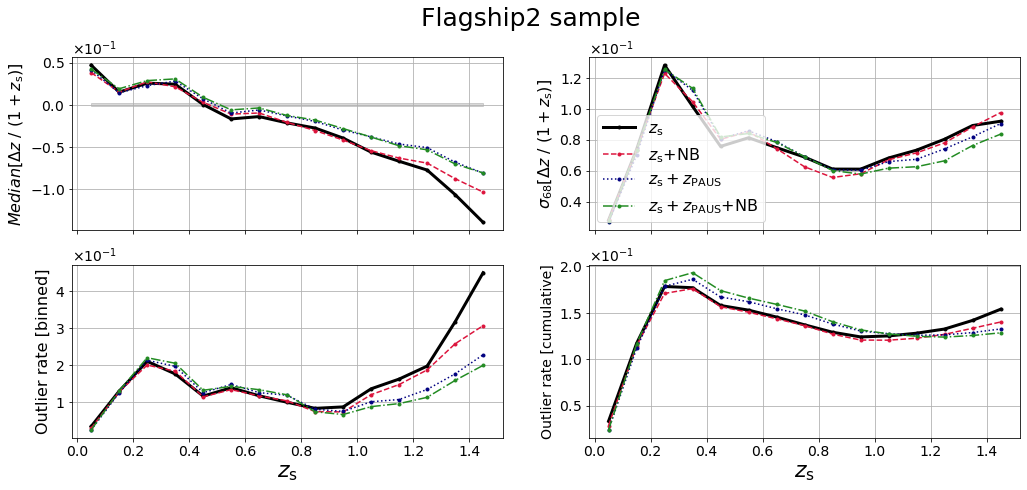

In [107]:
import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
fig,ax = plt.subplots(ncols = 2, nrows = 2, sharex=True, figsize = (17,7))
st = fig.suptitle("Flagship2 sample", fontsize=25)


from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax[0,0].yaxis.set_major_formatter(formatter) 
ax[0,1].yaxis.set_major_formatter(formatter) 
ax[1,0].yaxis.set_major_formatter(formatter) 
ax[1,1].yaxis.set_major_formatter(formatter) 


ax[0,0].plot(xlab,bias_bb, ls = '-', marker = '.', color = 'black',lw = 3)
ax[0,0].plot(xlab,bias_bbnb, ls = '--', marker = '.', color = 'crimson')
ax[0,0].plot(xlab,bias_bbz, ls = ':', marker = '.', color = 'navy')
ax[0,0].plot(xlab,bias_bbnbz, ls = '-.', marker = '.', color = 'forestgreen')
ax[0,0].fill_between(xlab,-0.002,0.002, color = 'grey', alpha = 0.3)



ax[0,1].plot(xlab,s68_bb, ls = '-', marker = '.', color = 'black',lw = 3, label = r'$z_{\rm s}$')
ax[0,1].plot(xlab,s68_bbnb, ls = '--', marker = '.', color = 'crimson', label = r'$z_{\rm s}$+NB')
ax[0,1].plot(xlab,s68_bbz, ls = ':', marker = '.', color = 'navy', label = r'$z_{\rm s}+z_{\rm PAUS}$')
ax[0,1].plot(xlab,s68_bbnbz, ls = '-.', marker = '.', color = 'forestgreen', label = r'$z_{\rm s}+z_{\rm PAUS}$+NB')
#ax[0,1].fill_between(xlab,0,0.05, color = 'grey', alpha = 0.3)


ax[1,0].plot(xlab,outliers_bb, ls = '-', marker = '.', color = 'black',lw = 3)
ax[1,0].plot(xlab,outliers_bbnb, ls = '--', marker = '.', color = 'crimson')
ax[1,0].plot(xlab,outliers_bbz, ls = ':', marker = '.', color = 'navy')
ax[1,0].plot(xlab,outliers_bbnbz, ls = '-.', marker = '.', color = 'forestgreen')

ax[1,1].plot(xlab,outliers_bb_cum, ls = '-', marker = '.', color = 'black',lw = 3)
ax[1,1].plot(xlab,outliers_bbnb_cum, ls = '--', marker = '.', color = 'crimson')
ax[1,1].plot(xlab,outliers_bbz_cum, ls = ':', marker = '.', color = 'navy')
ax[1,1].plot(xlab,outliers_bbnbz_cum, ls = '-.', marker = '.', color = 'forestgreen')

ax[0,1].legend(fontsize = 16)

ax[0,0].grid()
ax[1,0].grid()
ax[0,1].grid()
ax[1,1].grid()


ax[0,0].set_ylabel(r'$Median[\Delta z\ /\ (1 + z_{\rm s})]$', fontsize = 16)
ax[0,1].set_ylabel(r'$\sigma_{68}[\Delta z\ /\ (1 + z_{\rm s})]$', fontsize = 16)
ax[1,0].set_ylabel(r'Outlier rate [binned]', fontsize = 16)
ax[1,1].set_ylabel(r'Outlier rate [cumulative]', fontsize = 14)
#ax[1,1].set_xlabel(r'$z_{\rm PAUS+Cosmos}$', fontsize = 22)
#ax[1,0].set_xlabel(r'$z_{\rm PAUS+Cosmos}$', fontsize = 22)
ax[1,1].set_xlabel(r'$z_{\rm s}$', fontsize = 22)
ax[1,0].set_xlabel(r'$z_{\rm s}$', fontsize = 22)

plt.savefig('/data/astro/scratch/lcabayol/Euclid/referee_report/figures/flagship_zs.pdf', bbox_inches = 'tight')
